# Ocular Disease Recognition

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")

print("Path to dataset files:", path)

100%|██████████| 1.62G/1.62G [00:22<00:00, 76.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2


In [3]:
dataset_path = "/root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2"
files = os.listdir(dataset_path)
print(files)

['ODIR-5K', 'full_df.csv', 'preprocessed_images']


In [4]:
csv_path = f"{dataset_path}/full_df.csv"

df = pd.read_csv(csv_path)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [6]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [7]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [8]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [9]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [10]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [11]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [12]:
print(len(cataract),len(normal))

594 500


In [13]:
disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
df['labels_onehot'] = df[disease_columns].values.tolist()

In [14]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/root/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [15]:
dataset = create_dataset(cataract,1)
len(dataset)

100%|██████████| 594/594 [00:01<00:00, 414.19it/s]


588

In [16]:
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 500/500 [00:01<00:00, 276.49it/s]


1088

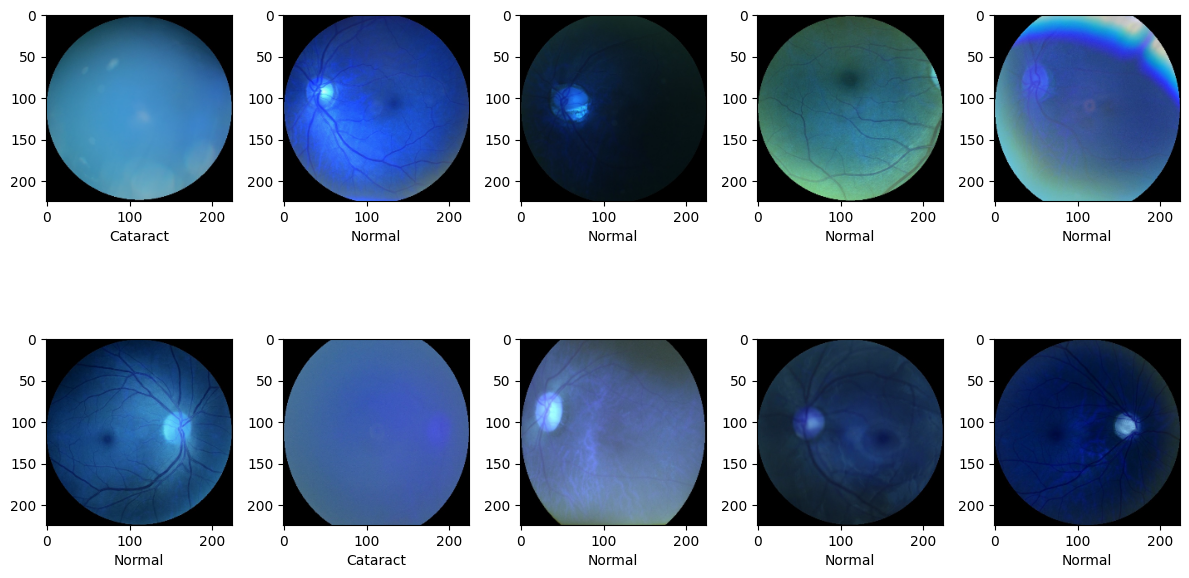

In [17]:
plt.figure(figsize=(12, 7))
for i in range(10):
    if len(dataset) > 0:  # Check if dataset is empty before proceeding
        sample = random.choice(range(len(dataset)))
        image = dataset[sample][0]
        category = dataset[sample][1]
        if category == 0:
            label = "Normal"
        else:
            label = "Cataract"
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.xlabel(label)
    else:
        print("Dataset is empty. Skipping plotting.")
        break  # Exit the loop if dataset is empty

plt.tight_layout()

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])
print(f"Dataset length: {len(dataset)}")

Dataset length: 1088


In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [20]:
df[['labels_onehot']].head()

,labels_onehot
0,"[0, 0, 0, 1, 0, 0, 0, 0]"
1,"[1, 0, 0, 0, 0, 0, 0, 0]"
2,"[0, 1, 0, 0, 0, 0, 0, 1]"
3,"[0, 1, 0, 0, 0, 0, 0, 1]"
4,"[0, 1, 0, 0, 0, 0, 0, 0]"


In [21]:
df.isnull().sum()

,0
ID,0
Patient Age,0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,0
D,0
G,0


In [22]:
df.describe(include='all')

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,H,M,O,filepath,labels,target,filename,left_cataract,right_cataract,labels_onehot
count,6392.000000,6392.000000,6392,6392,6392,6392,6392,6392.000000,6392.000000,6392.000000,...,6392.000000,6392.000000,6392.000000,6392,6392,6392,6392,6392.000000,6392.000000,6392
unique,NaN,NaN,2,3358,3358,196,205,NaN,NaN,NaN,...,NaN,NaN,NaN,6392,8,8,6392,NaN,NaN,37
top,NaN,NaN,Male,0_left.jpg,0_right.jpg,normal fundus,normal fundus,NaN,NaN,NaN,...,NaN,NaN,NaN,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,NaN,NaN,"[1, 0, 0, 0, 0, 0, 0, 0]"
freq,NaN,NaN,3424,2,2,2796,2705,NaN,NaN,NaN,...,NaN,NaN,NaN,1,2873,2873,1,NaN,NaN,2101
mean,2271.150814,57.857947,NaN,NaN,NaN,NaN,NaN,0.328692,0.332134,0.062109,...,0.031758,0.047872,0.248436,NaN,NaN,NaN,NaN,0.047559,0.045369,NaN
std,1417.559018,11.727737,NaN,NaN,NaN,NaN,NaN,0.469775,0.471016,0.241372,...,0.175370,0.213513,0.432139,NaN,NaN,NaN,NaN,0.212849,0.208129,NaN
min,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
25%,920.750000,51.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
50%,2419.500000,59.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
75%,3294.000000,66.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN


In [23]:
df[['N', 'G', 'C', 'C', 'A', 'H', 'M', 'O']].sum()

,0
N,2101
G,397
C,402
C,402
A,319
H,203
M,306
O,1588


In [24]:
df['labels'].value_counts()

,count
labels,
['N'],2873
['D'],1608
['O'],708
['C'],293
['G'],284
['A'],266
['M'],232
['H'],128


<ipython-input-25-2a17964ac2c9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='viridis')


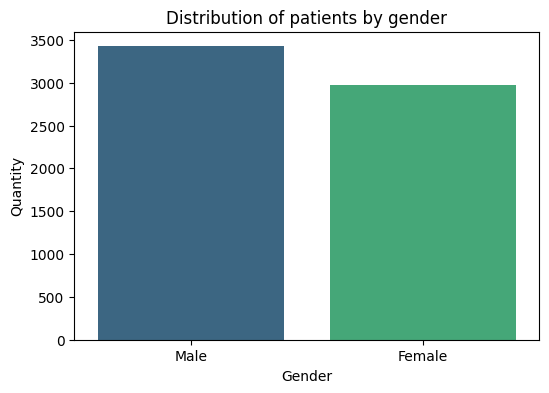

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gender distribution
gender_counts = df['Patient Sex'].value_counts()

# Draw chart
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='viridis')
plt.title("Distribution of patients by gender")
plt.xlabel("Gender")
plt.ylabel("Quantity")
plt.show()

<ipython-input-26-26b8c5260d8e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_columns, y=disease_counts, palette='coolwarm')


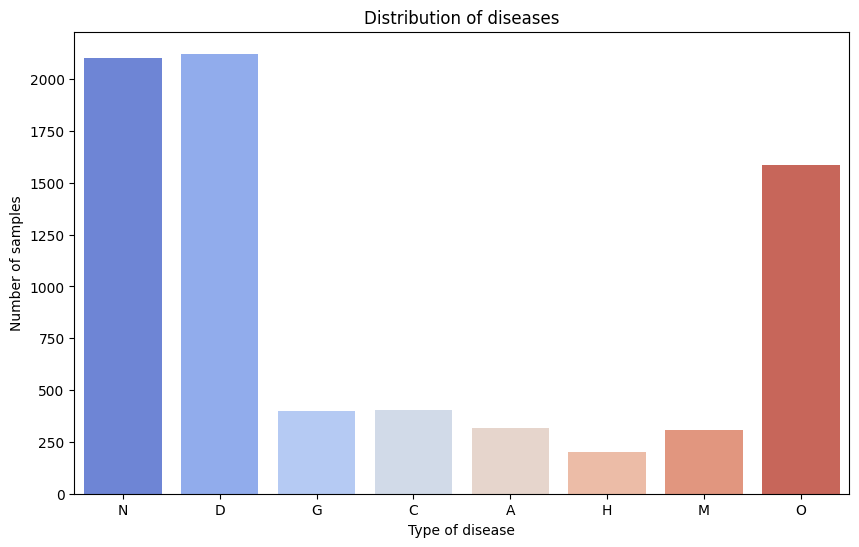

Percentage of diseases:
N    28.243043
D    28.538782
G     5.336739
C     5.403952
A     4.288211
H     2.728861
M     4.113456
O    21.346955
dtype: float64


In [26]:
# Calculate the total number of samples for each disease type
disease_counts = df[disease_columns].sum()

# Draw chart
plt.figure(figsize=(10, 6))
sns.barplot(x=disease_columns, y=disease_counts, palette='coolwarm')
plt.title("Distribution of diseases")
plt.xlabel("Type of disease")
plt.ylabel("Number of samples")
plt.show()

# Show percentage of diseases
print("Percentage of diseases:")
print((disease_counts / disease_counts.sum()) * 100)

<ipython-input-27-8e25e659f5b7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_distribution.index, y=disease_distribution.values, palette='magma')


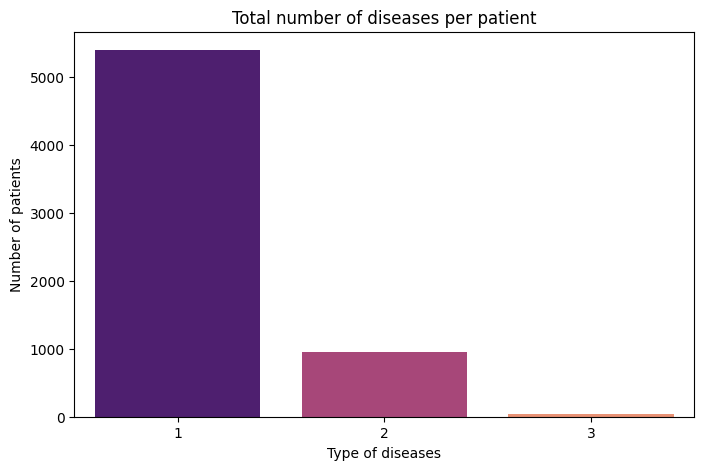

In [27]:
# Calculate the total number of diseases per patient
df['total_diseases'] = df[disease_columns].sum(axis=1)

# Distribution of disease numbers
disease_distribution = df['total_diseases'].value_counts()

# Draw chart
plt.figure(figsize=(8, 5))
sns.barplot(x=disease_distribution.index, y=disease_distribution.values, palette='magma')
plt.title("Total number of diseases per patient")
plt.xlabel("Type of diseases")
plt.ylabel("Number of patients")
plt.show()

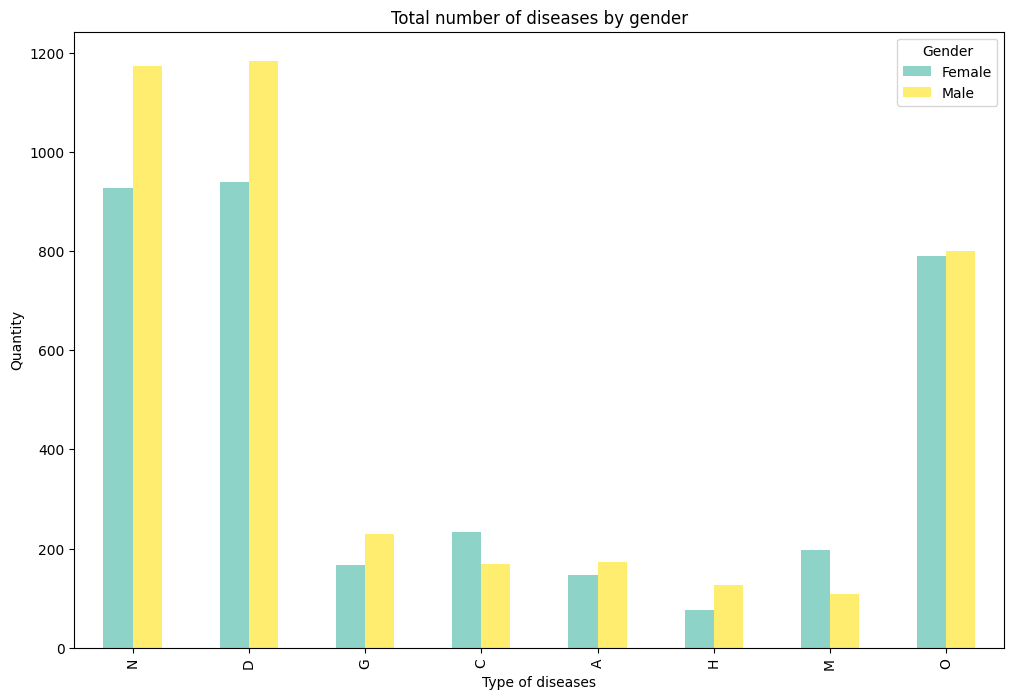

In [28]:
# Calculate total number of diseases by gender
disease_by_gender = df.groupby('Patient Sex')[disease_columns].sum()

# Draw chart
disease_by_gender.T.plot(kind='bar', figsize=(12, 8), colormap='Set3')
plt.title("Total number of diseases by gender")
plt.xlabel("Type of diseases")
plt.ylabel("Quantity")
plt.legend(title="Gender", loc="upper right")
plt.show()

<ipython-input-29-4ad73929203f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=normal_vs_abnormal.index, y=normal_vs_abnormal.values, palette='pastel')


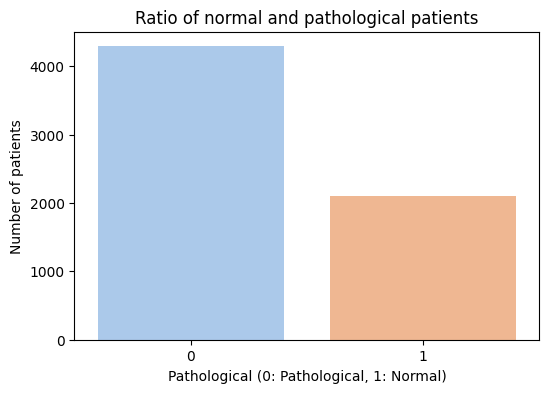

In [29]:
# 0: Pathological, 1: Normal
normal_vs_abnormal = df['N'].value_counts()

# Draw chart
plt.figure(figsize=(6, 4))
sns.barplot(x=normal_vs_abnormal.index, y=normal_vs_abnormal.values, palette='pastel')
plt.title("Ratio of normal and pathological patients")
plt.xlabel("Pathological (0: Pathological, 1: Normal)")
plt.ylabel("Number of patients")
plt.show()

## VGG19

In [30]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
for layer in vgg.layers:
    layer.trainable = False

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model1 = Sequential()
model1.add(vgg)
model1.add(Flatten())
model1.add(Dense(1,activation="sigmoid"))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,049,473 (76.48 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [33]:
model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.keras",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1, mode="max")

In [35]:
history1 = model1.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 879s 32s/step - accuracy: 0.7711 - loss: 2.8552 - val_accuracy: 0.9450 - val_loss: 1.0953
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 894s 31s/step - accuracy: 0.9477 - loss: 0.7458 - val_accuracy: 0.9450 - val_loss: 0.5591
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 842s 30s/step - accuracy: 0.9903 - loss: 0.0594 - val_accuracy: 0.9404 - val_loss: 0.5673
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 864s 30s/step - accuracy: 0.9989 - loss: 0.0058 - val_accuracy: 0.9404 - val_loss: 0.6166
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 840s 30s/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 0.9312 - val_loss: 0.8321
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 873s 31s/step - accuracy: 0.9895 - loss: 0.0177 - val_accuracy: 0.9312 - val_loss: 0.8379
Epoch 6: early stopping


In [36]:
loss,accuracy = model1.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 183s 25s/step - accuracy: 0.9309 - loss: 0.9959
loss: 0.8379098773002625
Accuracy: 0.9311926364898682


In [37]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred1 = (model1.predict(x_test) > 0.5).astype("int32")
accuracy_score(y_test, y_pred1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 168s 24s/step


0.9311926605504587

In [38]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       106
           1       0.89      0.98      0.94       112

    accuracy                           0.93       218
   macro avg       0.94      0.93      0.93       218
weighted avg       0.94      0.93      0.93       218



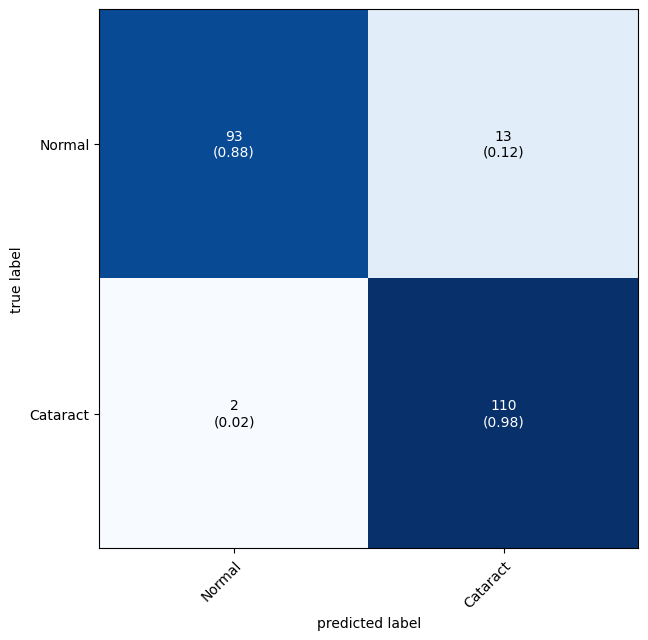

In [39]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred1)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

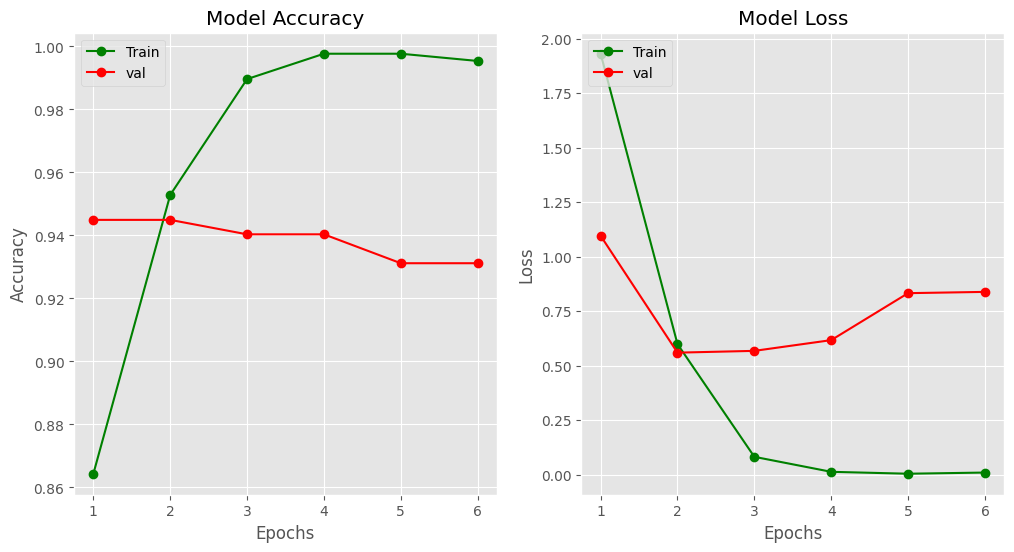

In [41]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))

num_epochs_trained = len(history1.history["accuracy"])
epochs = range(1, num_epochs_trained + 1)


plt.subplot(1,2,1)
plt.plot(epochs,history1.history["accuracy"],"go-")
plt.plot(epochs,history1.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history1.history["loss"],"go-")
plt.plot(epochs,history1.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

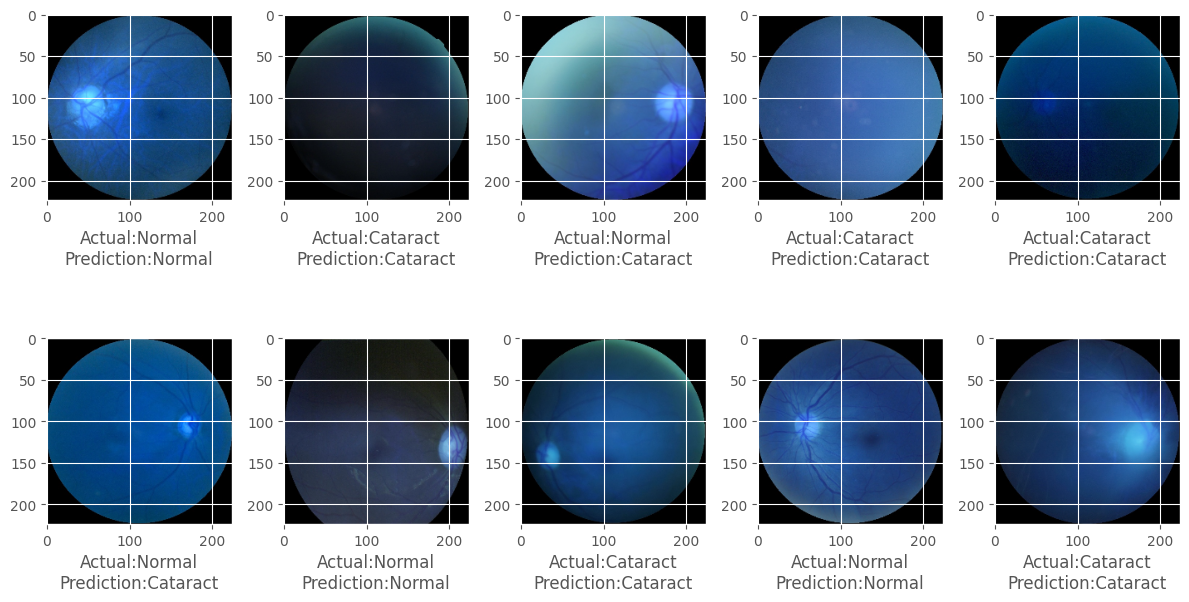

In [42]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred1[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

## ResNet50

In [43]:
from tensorflow.keras.applications.resnet50 import ResNet50
rnet = ResNet50(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [44]:
for layer in rnet.layers:
    layer.trainable = False

In [45]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model2 = Sequential()
model2.add(rnet)
model2.add(Flatten())
model2.add(Dense(1,activation="sigmoid"))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         100,353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [46]:
model2.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("rnet50.keras",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [48]:
history2 = model2.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7680 - loss: 2.8067
Epoch 1: val_accuracy improved from -inf to 0.91284, saving model to rnet50.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 217s 8s/step - accuracy: 0.7715 - loss: 2.7701 - val_accuracy: 0.9128 - val_loss: 1.3790
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9379 - loss: 0.5336
Epoch 2: val_accuracy improved from 0.91284 to 0.93578, saving model to rnet50.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 298s 9s/step - accuracy: 0.9383 - loss: 0.5310 - val_accuracy: 0.9358 - val_loss: 0.7567
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9786 - loss: 0.0908
Epoch 3: val_accuracy improved from 0.93578 to 0.96330, saving model to rnet50.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.9786 - loss: 0.0910 - val_accuracy: 0.9633 - val_loss: 0.4026
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9987 - loss: 0.0114
Epoch 4: val_accuracy did not improve from 0.96330
28/28 ━━━━━━━━━━━

In [49]:
loss,accuracy = model2.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.9557 - loss: 0.7086
loss: 0.5124424695968628
Accuracy: 0.963302731513977


In [50]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred2 = (model2.predict(x_test) > 0.5).astype("int32")
accuracy_score(y_test, y_pred2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step


0.963302752293578

In [51]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       106
           1       0.95      0.98      0.96       112

    accuracy                           0.96       218
   macro avg       0.96      0.96      0.96       218
weighted avg       0.96      0.96      0.96       218



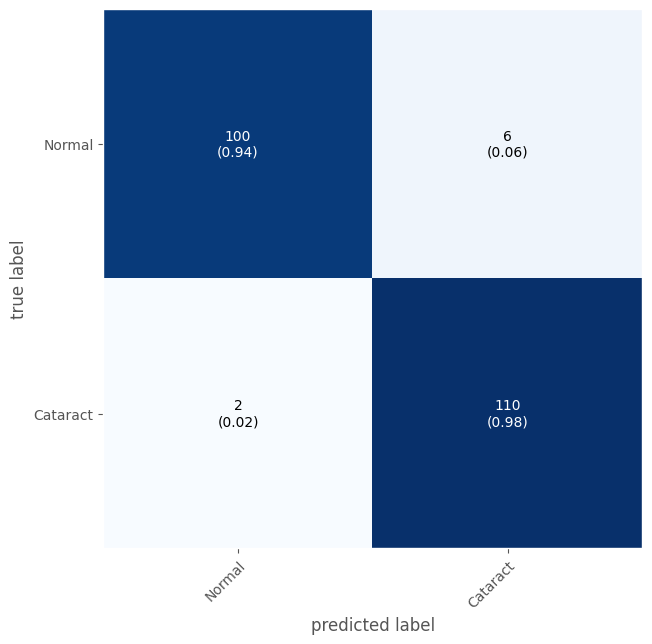

In [52]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

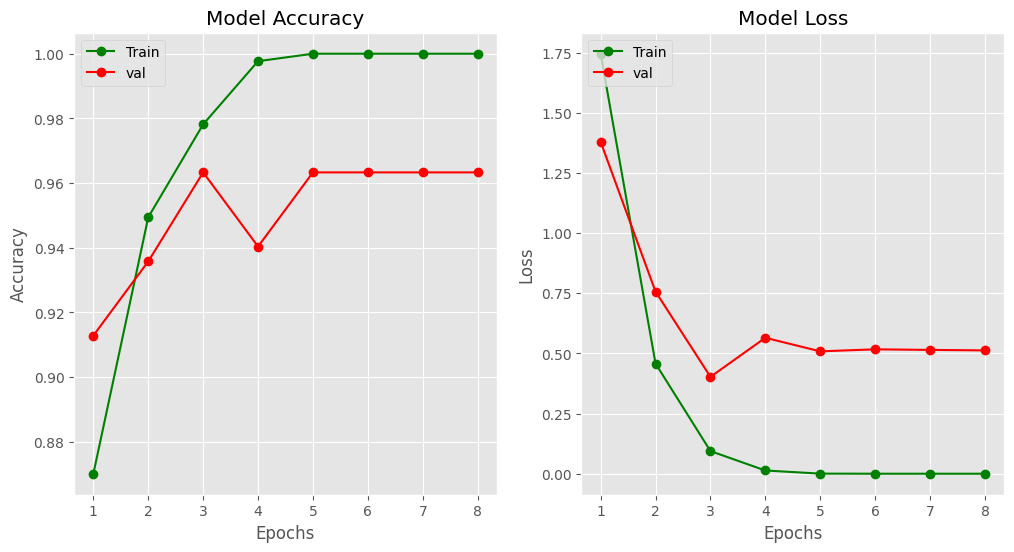

In [57]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))

num_epochs_trained = len(history2.history["accuracy"])
epochs = range(1, num_epochs_trained + 1)

plt.subplot(1,2,1)
plt.plot(epochs,history2.history["accuracy"],"go-")
plt.plot(epochs,history2.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history2.history["loss"],"go-")
plt.plot(epochs,history2.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

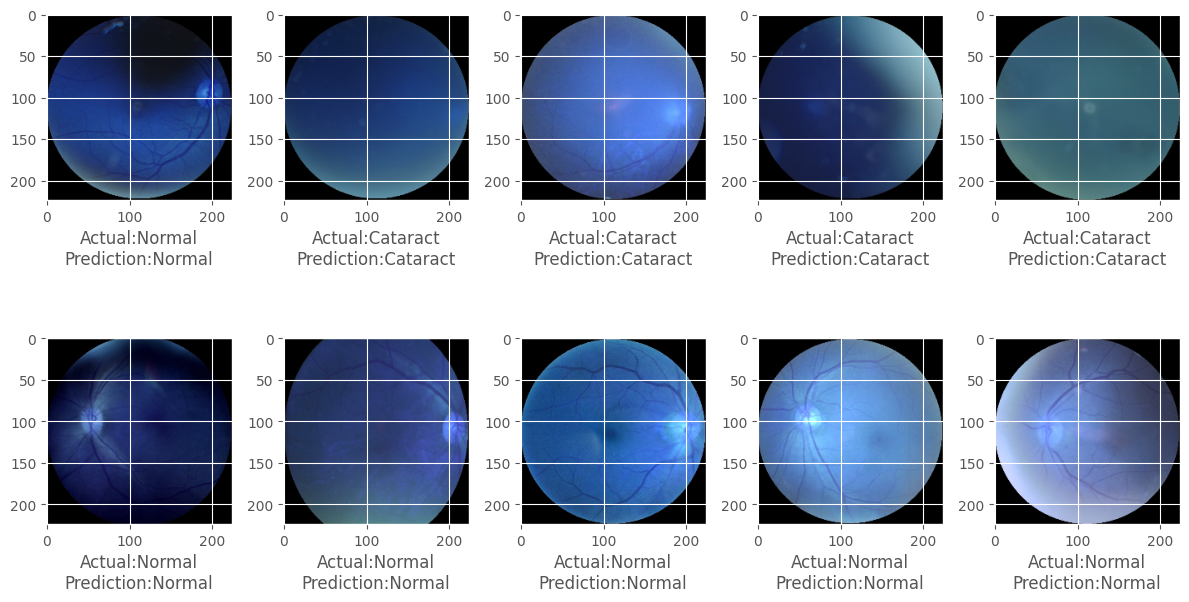

In [55]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred2[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

## Vision transformers

In [77]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [62]:
num_classes = 2
input_shape = (224, 224, 3)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (870, 224, 224, 3) - y_train shape: (870,)
x_test shape: (218, 224, 224, 3) - y_test shape: (218,)


In [63]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
image_size = 128 # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

In [64]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [65]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [66]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 6 X 6
Patches per image: 441
Elements per patch: 108


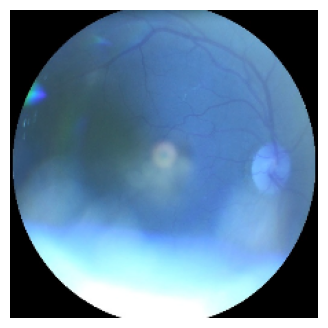

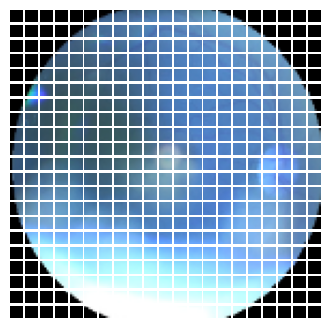

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [68]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [69]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model3 = keras.Model(inputs=inputs, outputs=logits)
    return model3

In [70]:
model3 = create_vit_classifier()
model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 128, 128, 3)    │              7 │ input_layer_4[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_1 (Patches)       │ (None, None, 108)      │              0 │ data_augmentation[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 441, 64)        │         35,200 │ patches_1[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 441, 64)        │            128 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 441, 64)        │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 441, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 441, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 441, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 441, 128)       │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 441, 64)        │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 441, 64)        │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 441, 64)        │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 441, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 441, 64)        │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention) 

 Total params: 15,117,577 (57.67 MB)

 Trainable params: 15,117,570 (57.67 MB)

 Non-trainable params: 7 (32.00 B)

In [71]:
num_epochs = 30

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

model3.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

checkpoint_filepath = "/tmp/checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,)

#earlystop = EarlyStopping(monitor="val_accuracy",patience=10,verbose=1)

history3 = model3.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

model3.load_weights(checkpoint_filepath)
_, accuracy = model3.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 320s 12s/step - accuracy: 0.5579 - loss: 5.5917 - val_accuracy: 0.4943 - val_loss: 1.7002
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 320s 12s/step - accuracy: 0.5337 - loss: 2.2767 - val_accuracy: 0.6092 - val_loss: 0.7913
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 317s 11s/step - accuracy: 0.5662 - loss: 1.3896 - val_accuracy: 0.5402 - val_loss: 0.9705
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 318s 11s/step - accuracy: 0.5709 - loss: 1.0239 - val_accuracy: 0.7241 - val_loss: 0.5753
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 330s 11s/step - accuracy: 0.5993 - loss: 0.7443 - val_accuracy: 0.6092 - val_loss: 0.6331
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 313s 11s/step - accuracy: 0.5859 - loss: 0.8203 - val_accuracy: 0.6092 - val_loss: 0.5872
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 333s 12s/step - accuracy: 0.5957 - loss: 0.7513 - val_accuracy: 0.5977 - val_loss: 0.6213
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 312s 11s/step - accuracy: 0.6508 - loss: 0.6340 - val_accuracy: 0.

In [82]:
loss, accuracy = model3.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8371 - loss: 0.3727
loss: 0.3646199405193329
Accuracy: 0.8256880640983582


In [83]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

In [84]:
len(val_acc),len(val_loss),len(acc),len(loss)

(30, 30, 30, 30)

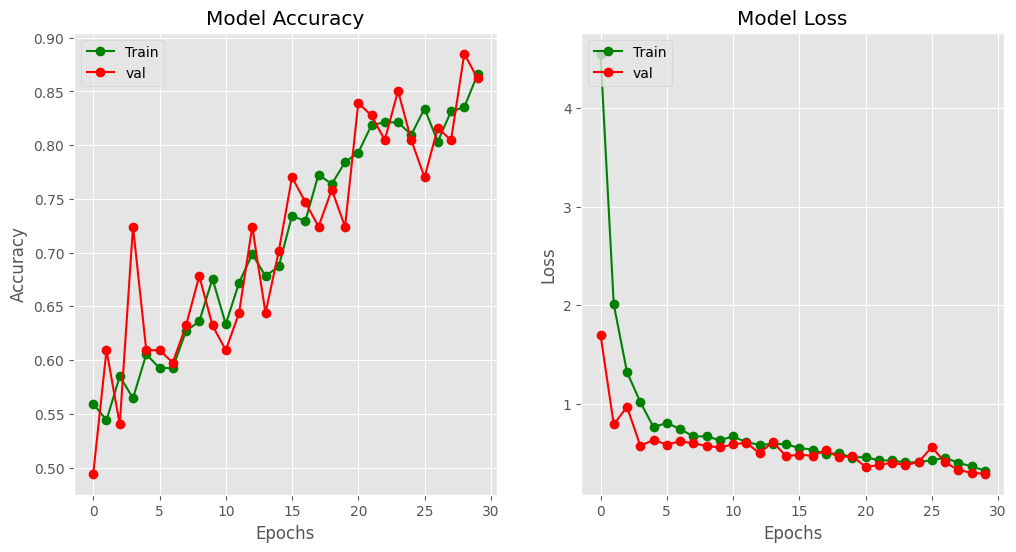

In [85]:
import matplotlib.pyplot as plt
EPOCHS = 30

plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history3.history['accuracy'],"go-")
plt.plot(range(EPOCHS), history3.history['val_accuracy'],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history3.history['loss'],"go-")
plt.plot(range(EPOCHS), history3.history['val_loss'],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

# Comparison

In [86]:
accloss = {'Model':['VGG19','ResNet50','Vision Transformer'],
           'Training_Accuracy':[max(history1.history['accuracy']),max(history2.history['accuracy']),max(history3.history['accuracy'])],
           'Training_Loss':[min(history1.history['loss']),min(history2.history['loss']),min(history3.history['loss'])],
           'Validation_Accuracy':[max(history1.history['val_accuracy']),max(history2.history['val_accuracy']),max(history3.history['val_accuracy'])],
           'Validation_Loss':[min(history1.history['val_loss']),min(history2.history['val_loss']),min(history3.history['val_loss'])]}

In [87]:
accloss

{'Model': ['VGG19', 'ResNet50', 'Vision Transformer'],
 'Training_Accuracy': [0.9977011680603027, 1.0, 0.8659003973007202],
 'Training_Loss': [0.00360657274723053,
  2.057422352663707e-05,
  0.32392653822898865],
 'Validation_Accuracy': [0.9449541568756104,
  0.963302731513977,
  0.8850574493408203],
 'Validation_Loss': [0.5591256022453308,
  0.4025544226169586,
  0.29159215092658997]}

In [89]:
comp = pd.DataFrame.from_dict(accloss)
comp

,Model,Training_Accuracy,Training_Loss,Validation_Accuracy,Validation_Loss
0,VGG19,0.997701,0.003607,0.944954,0.559126
1,ResNet50,1.000000,0.000021,0.963303,0.402554
2,Vision Transformer,0.865900,0.323927,0.885057,0.291592
